$\newcommand{\n}[1]{\|#1 \|}$
$\renewcommand{\a}{\alpha}$
$\renewcommand{\b}{\beta}$
$\renewcommand{\c}{\gamma}$
$\renewcommand{\d}{\delta}$
$\newcommand{\la}{\lambda}$
$\newcommand{\e}{\varepsilon}$
$\renewcommand{\t}{\tau}$
$\renewcommand{\th}{\theta}$
$\newcommand{\s}{\sigma}$
$\newcommand{\x}{\bar x}$
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator{\sign}{sign}$

## **Optimal transport**



In [1]:
using LinearAlgebra
using Plots
using Random
using Distributions

### Matrix scaling and bipartite graphs

In [20]:
#m, n = 50, 50
m, n = 3, 3

#A = rand(Bernoulli(0.5), (m, n))
A = [1.0 1 1; 1 0 0.0; 1.0 0 0]

r = ones(m) / m
c = ones(n) / n;

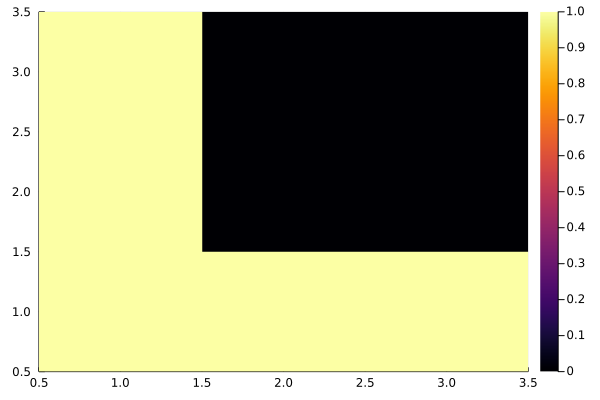

In [18]:
heatmap(A)

In [2]:
function row_norms(A, p=1)
    [norm(A[i,:], p) for i in 1:size(A)[1]]
end

function col_norms(A, p=1)
    [norm(A[:, j], p) for j in 1:size(A)[2]]
end

function is_doubly_stoch(A, tol=1e-10)
    n = size(A)[1]
    p = ones(n)/n
    s = norm(row_norms(A, 1) - p, 1) + norm(col_norms(A, 1) - p, 1)
    return s <= tol ? true : false
end

function sinkhorn(A, c, r, iter)
    m, n = size(A)
    x = ones(m)
    y = ones(n)
    B = A
    energy = [norm(row_norms(B) - r, 1)]
    for i in 1:iter
        #write code here:
        x = r./(A*y)
        y = c./(transpose(A)*x)
        B = x.*A.*y'
        energy_k = norm(row_norms(B) - r, 1)
        append!(energy, energy_k)
    end
    return energy, B, x, y
end
;

(50, 50)

In [21]:
energy, B, x, y = sinkhorn(A, c, r, 10);

#### Show matrix B

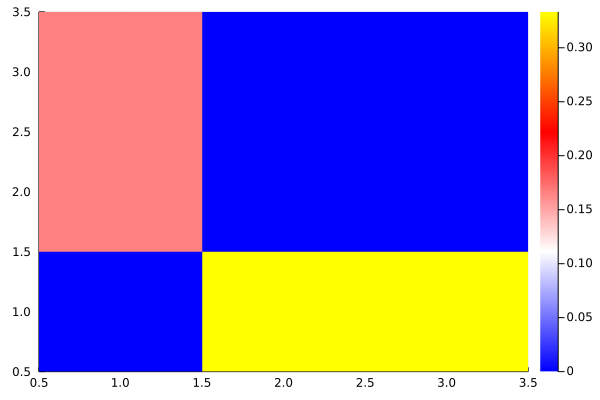

In [22]:
heatmap(B, c=cgrad([:blue, :white,:red, :yellow]))

#### Check how the error decays

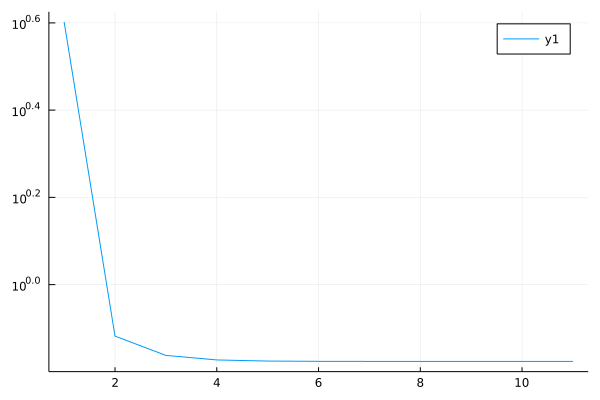

In [23]:
plot(energy, yscale=:log10)

### Optimal transport between two clouds of points

We generate data in a some specific shape (not important)

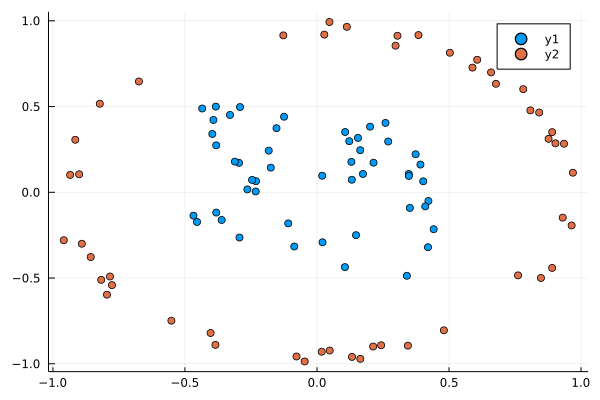

In [24]:
m, n = 50, 50 
x = rand(2, m) .- 0.5
θ = 2*π*rand(1, n)
r = 0.9 .+ 0.1*rand(1, n)
y = [cos.(θ) .* r; sin.(θ) .* r];

p = ones(m) / m
q = ones(n) / n;

scatter(x[1,:], x[2,:])
scatter!(y[1,:], y[2,:])

#### Define the cost matrix $C$ via the standard Euclidean norm
$C_{ij} = \n{x_i - y_j}^2$


In [28]:
C = (x[1,:] .- y[1, :]').^2 .+ (x[2,:] .- y[2, :]').^2;
C


50×50 Matrix{Float64}:
 1.09937   0.766899  1.17717   0.911123  …  1.01993   1.13638   0.82318
 0.930282  1.29475   2.14606   0.488788     1.62256   1.80076   1.49871
 1.85614   0.349816  1.35031   1.64429      1.42324   1.52913   0.354578
 0.813253  1.44387   2.1021    0.397119     1.54361   1.72005   1.65074
 1.22598   0.965709  0.579903  1.29575      0.628908  0.692753  0.912762
 0.443145  1.76356   0.582811  0.544746  …  0.321917  0.399977  1.77996
 1.53612   0.469263  1.56158   1.22749      1.4576    1.58936   0.539584
 1.58067   0.445993  1.41088   1.32522      1.36705   1.48689   0.489442
 1.78423   0.377591  1.93531   1.3693       1.81251   1.96186   0.476575
 0.64417   1.31122   1.40276   0.413944     0.996194  1.13453   1.43856
 1.95929   0.428519  1.09484   1.86395   …  1.27307   1.35445   0.380952
 0.37158   1.77535   0.77926   0.398348     0.436294  0.530985  1.82893
 1.21504   0.871304  2.04229   0.771606     1.66822   1.8375    1.03879
 ⋮                                 

#### The next code is not important, use it as a black box. We only want to solve the linear program above. It is adapted from 
https://jump.dev/JuMP.jl/stable/tutorials/Mixed-integer%20linear%20programs/transp/

In [33]:
using JuMP
import GLPK
import Test

function example_transp()
	supply = p 
	demand = q
	cost = C
	model = Model(GLPK.Optimizer)
	@variable(model, trans[1:m, 1:n] >= 0)
	@objective(
		model,
		Min,
		sum(
			cost[i, j] * trans[i, j]
			for i in 1:m, j in 1:n
		)
	)
	@constraints(model, begin
		[i in 1:m], sum(trans[i, :]) == supply[i]
		[j in 1:n], sum(trans[:, j]) == demand[j]
	end)
	optimize!(model)
    Test.@test termination_status(model) == MOI.OPTIMAL
	Test.@test primal_status(model) == MOI.FEASIBLE_POINT
	#println("The optimal solution is:")
	#println(value.(trans))
	return value.(trans)
end

transport = example_transp();


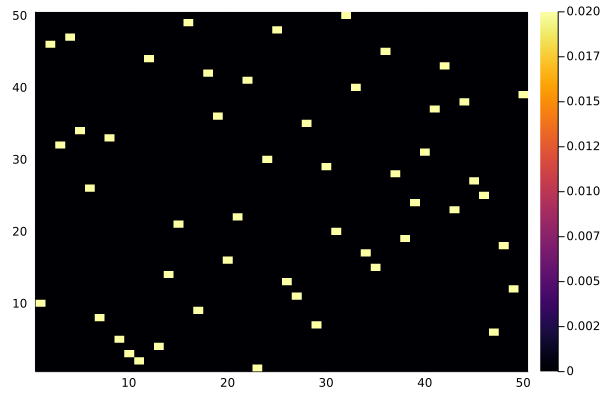

In [36]:
heatmap(transport)

#### Find the desired permutation from optimal plan.

In [34]:
transport_permutation = [argmax(transport[i,:]) for i in 1:m];

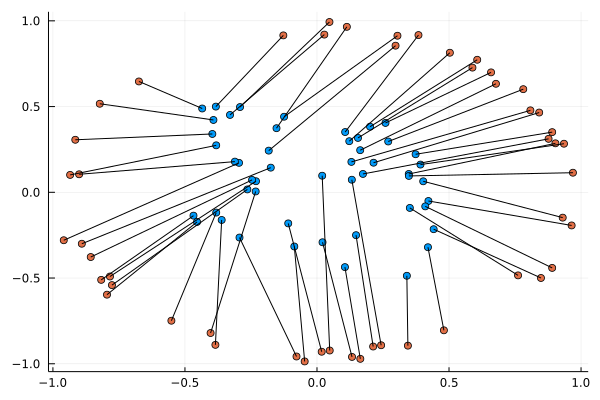

In [35]:
p = scatter(x[1,:], x[2,:])
scatter!(p, y[1,:], y[2,:])
for i in 1:m
    j = transport_permutation[i]
    plot!(p, [x[1, i], y[1, j]], [x[2, i], y[2, j]], color=:black, legend=:false)
end
p

### Optimal transport between histograms

Adapt Sinkhorn algorithm from matrix scaling to solve optimal transport with entropic regularization.

We will apply it to find an "optimal" plan between two histograms (from Gaussian disribution).
Our space $X = Y = [0, 1]$ 

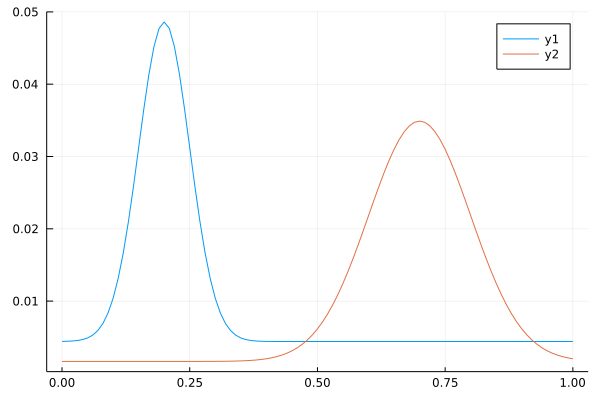

In [9]:
n = 100
space = collect(0:(1.0 / n):1)
mean1, mean2 = 0.2, 0.7
σ1, σ2 = 0.05, 0.1
#p = 0.1* exp.(-0.5*((space .- mean1)/σ1).^2) 
#q = 0.2* exp.(-0.5*((space .- mean2)/σ2).^2)

p = 0.1* exp.(-0.5*((space .- mean1)/σ1).^2) .+ 0.01 
q = 0.2* exp.(-0.5*((space .- mean2)/σ2).^2) .+ 0.01

p = p / norm(p, 1)
q = q / norm(q, 1)
plot(space, p)
plot!(space, q)

In [10]:
C = (space .- space').^2
ϵ = 0.05;
K = exp.(C/ϵ)

101×101 Matrix{Float64}:
 1.0        1.002      1.00803    …  2.1975e8   3.25867e8  4.85165e8
 1.002      1.0        1.002         1.48783e8  2.1975e8   3.25867e8
 1.00803    1.002      1.0           1.01138e8  1.48783e8  2.1975e8
 1.01816    1.00803    1.002         6.90264e7  1.01138e8  1.48783e8
 1.03252    1.01816    1.00803       4.7299e7   6.90264e7  1.01138e8
 1.05127    1.03252    1.01816    …  3.25406e7  4.7299e7   6.90264e7
 1.07466    1.05127    1.03252       2.24769e7  3.25406e7  4.7299e7
 1.10296    1.07466    1.05127       1.55878e7  2.24769e7  3.25406e7
 1.13655    1.10296    1.07466       1.08535e7  1.55878e7  2.24769e7
 1.17586    1.13655    1.10296       7.5874e6   1.08535e7  1.55878e7
 1.2214     1.17586    1.13655    …  5.32541e6  7.5874e6   1.08535e7
 1.27379    1.2214     1.17586       3.75275e6  5.32541e6  7.5874e6
 1.33376    1.27379    1.2214        2.65512e6  3.75275e6  5.32541e6
 ⋮                                ⋱                        ⋮
 7.5874e6   5.32541e

How to apply Sinkhorn for this problem?

In [13]:
energy, γ, _, _ = sinkhorn(K, p, q, 500);

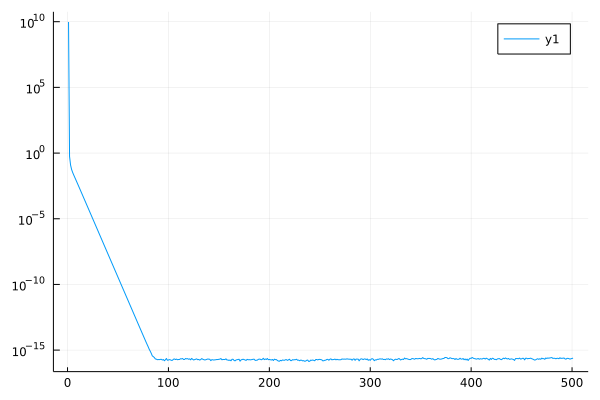

In [15]:
plot(energy, yaxis=:log10)

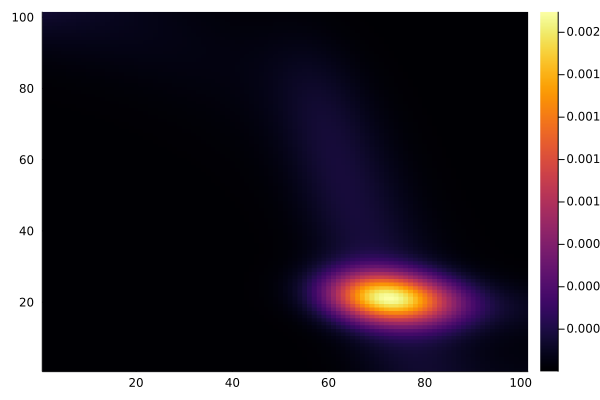

In [14]:
heatmap(γ')

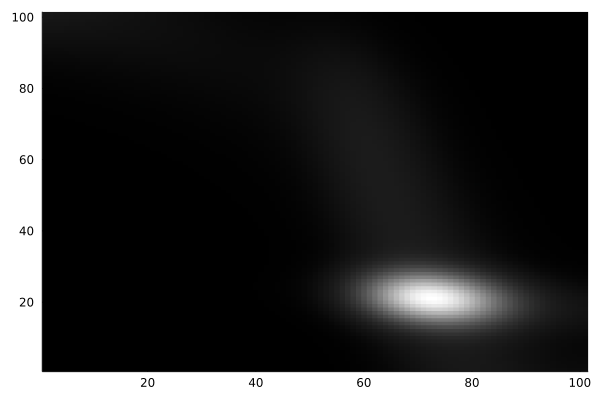

In [16]:
heatmap(γ', color = :greys, legend = :none)

#### Let's make a fancy plot (doesn't work at the moment)

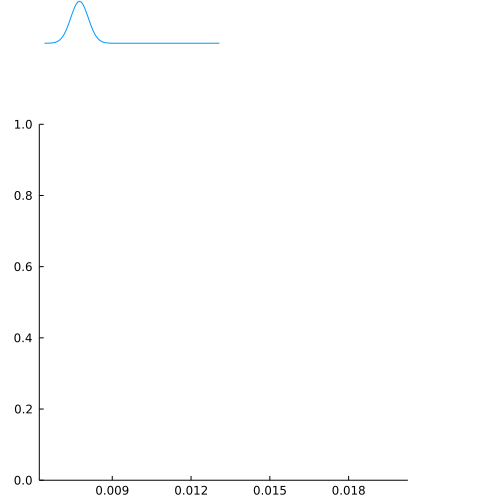

In [64]:
layout = @layout [   a         _
                  b ;  c{0.8w,0.8h}]

default(fillcolor = :darkgrey, markercolor = :white, grid = false, legend = false)
plot(layout = layout, link = :both, size = (500, 500), margin = -10Plots.px)
#scatter!(p,q, subplot = 2, framestyle = :box)
#heatmap(γ', color = :greys, legend = :none)
plot!([p q], subplot = [1 2],  framestyle=:none, orientation=[:v :h])
#plot!(q, subplot=1, orientation=:v,framestyle=:none)
#plot!(q, subplot=3, orientation=:h,framestyle=:none)
